# Zillow Time Series Modelling

![buildings](images/buildings.png)

## Author: [Patricio Contreras](https://www.linkedin.com/in/pcontreras97/)

## Overview

Now that we've selected our 5 best zip codes, we can start creating time series models to predict values into the future.  In this notebook, we'll create our initial time series models for each zip code and evaluate their performance.

## Load the Data

We load in the top 5 zip codes data we left off in the [EDA](EDA.ipynb) notebook:

In [1]:
# importing necessary Python libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# importing top 5 time series data
df_top5 = pd.read_csv("data/df_top5.csv", index_col = 0)
# convert index to datetime for optimal plotting
df_top5.index = pd.to_datetime(df_top5.index)

df_top5.head()

,11216,33936,94804,11222,94301
2010-01-01,490200.0,46400.0,169900.0,608500.0,1710700.0
2010-02-01,490600.0,46300.0,170400.0,610000.0,1718100.0
2010-03-01,489000.0,46300.0,170100.0,599200.0,1715300.0
2010-04-01,483400.0,45500.0,167800.0,581600.0,1716500.0
2010-05-01,478500.0,44800.0,167000.0,577400.0,1723000.0


In [3]:
# print out dimensions of dataframe
print("Number of rows:", df_top5.shape[0])
print("Number of columns:", df_top5.shape[1])

Number of rows: 100
Number of columns: 5


As seen by the output above, we're working with the same zip codes as before.  The dimensions of the dataframe and values were left intact.

## Time Series Modelling - ARIMA

Given the nature of our time series data (upward trend, non-constant variance), we cannot safely say that it's *stationary*.  Normally, this would mean we have to manually detrend the data and make it resemble a white noise time series.  **However**, an Autoregressive Integrated Moving Average (ARIMA) time series model can do this for us!

Before we begin, let's double check our data has no missing values:

### Check for Missing Values

In [4]:
# check data has no missing values
df_top5.isna().sum()

11216    0
33936    0
94804    0
11222    0
94301    0
dtype: int64

No missing values.  Great!

Let's also test whether the time series data is *actually* non-stationary or not.  Rather than just visually inspecting the time series, we can use the Augmented Dickey-Fuller Test from `statsmodels` to verify our initial assumptions.  If the p-value is smaller than our threshold of 0.05, we can reject the null hypothesis that our time series data is not stationary.

### Check if Data is Already Stationary

In [5]:
from statsmodels.tsa.stattools import adfuller
# apply function to all columns and return p-value
df_top5.apply(lambda col: adfuller(col)[1])

11216    0.968008
33936    0.998171
94804    0.932422
11222    0.989531
94301    0.971189
dtype: float64

All of the p-values from the `adfuller()` test are greather than our threshold (0.05), which means we *cannot* reject the null hypothesis (our time series data is non-stationary).

### ARIMA Parameters `p`, `d`, and `q`

Given that ARIMA models are essentially a combination of Autoregressive (AR) and Moving Average (MA) time series models, they depend on the parameters `p`, `q`, and a new parameter, `d`.

#### `p` - the number of AR (Autoregressive) terms

`p` is the parameter used in AR time series models and represents the number of lags of Y to be used as predictors.  In other words, how many previous values should we consider when predicting the value at $t = x$?

#### `q` - the number of MA (Moving Average) terms

`q` is the order of the MA term.  It represents the number of lagged forecast errors that should be used to predict the value at $t = x$.

#### `d` - the number of differencing needed

ARIMA models have an AR component that resembles linear regression using lagged values as predictors.  That being the case, as with any other linear regression model, the predictors should have little to no correlation whatsoever and be independent of one another.  A common way to do this is by differencing the time series.  That is, subtract the previous value from the current value.

`d` is therefore the minimum number of differencing required to make the time series **stationary**.  If the time series is already stationary, `d` = 0

### Parameter Selection for the ARIMA Time Series Model

Finding the optimal values for `p`, `d`, and `q` can be challenging and there are many ways to go about this.  For this project, we'll use an exhaustive "grid search" method whereby we fit an ARIMA model for every possible combination of `p`, `d`, and `q`, and record the model's Akaike Information Criterion (AIC) score.  This score is used often for model selection as it estimates the quality of each model relative to each of the other models.  An ARIMA model that fits the data well with several features will be assigned a larger AIC score than a model that uses less features and achieves the same goodness of fit.  In other words, we often look for the model with the *lowest* AIC score.

---

Let's first define our parameter grid.  Each parameter will have a range from 0 to 5:

In [6]:
import itertools
p = d = q = range(6)
# every possible combination of p, d, and q
pdq = list(itertools.product(p,d,q))
# display preview
pdq[:5]

[(0, 0, 0), (0, 0, 1), (0, 0, 2), (0, 0, 3), (0, 0, 4)]

Now that we've defined our parameter grid, let's split our data into training and test sets.  This is done so that we can later evaluate how our model performs on unseen data.  Generally the split is done 70-30, with 70% of the data assigned to the training set and the rest assigned to the test set.  However, given the nature of our time series we shall perform an 80-20 split.  Why?  One reason is because our time series data is still affected by the 2008 housing market crash and we need more data to train our models in order to forecast with a higher degree of accuracy.

Remember, we have **5** zip codes.  Therefore, for each zip code, we fit an ARIMA model (using `statsmodels`) for each possible combination of parameter values.  We store the model's AIC score in a list and, once all models have been fitted, store the respective list in a dictionary:

In [7]:
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")

# split data in chronological order (80-20)
train = df_top5.iloc[:80,:]
test = df_top5.iloc[80:,:]

zipcode_AIC = {}
# for each zip code
for col in range(train.shape[1]):
    df = train.iloc[:,col]
    AIC = []
    zipcode = train.columns[col]
    # for each possible p, d, q combination
    for params in pdq:
        try:
            model = ARIMA(df, order = params)
            output = model.fit()
            # store model's AIC score
            AIC.append([params, output.aic])
        except:
            continue
    # store zip code's AIC list
    zipcode_AIC[zipcode] = AIC

We now have a dictionary with the AIC score of each model for each zip code.  Let's see which combination of parameter values resulted in the lowest AIC score for each zip code:

In [8]:
# printing out "optimal" parameter values and associated AIC score
for key in zipcode_AIC:
    print(key)
    result = sorted(zipcode_AIC[key], key = lambda x: x[1])[0]
    print("Best parameters:", result[0])
    print("AIC:", result[1])
    print("----------------------")

11216
Best parameters: (0, 5, 3)
AIC: 1557.2951757319786
----------------------
33936
Best parameters: (0, 2, 0)
AIC: 1107.7392325643038
----------------------
94804
Best parameters: (3, 0, 0)
AIC: 10.0
----------------------
11222
Best parameters: (2, 5, 2)
AIC: 1612.5097097962548
----------------------
94301
Best parameters: (3, 1, 1)
AIC: 10.0
----------------------


Interesting.  One zip code has `d` equal to 0, even though the time series was already deemed non-stationary.  Furthermore, 2 models have an AIC significantly lower than the other 3.

### Building the ARIMA Models and Checking Residual Diagnostics

Now that we have our initial "best" parameter values for each zip code, we can create our ARIMA models!  After fitting, we'll call `summary()` to inspect the coefficients and plot residual diagnostics using `plot_diagnostics()` to ensure there are no patterns:

In [9]:
# instantiate ARIMA object with optimal parameter values
ARIMA_11216 = ARIMA(train["11216"], order = (0,5,3))
ARIMA_33936 = ARIMA(train["33936"], order = (0,2,0))
ARIMA_94804 = ARIMA(train["94804"], order = (3,0,0))
ARIMA_11222 = ARIMA(train["11222"], order = (2,5,2))
ARIMA_94301 = ARIMA(train["94301"], order = (3,1,1))

# Fit the model and print results
output_11216 = ARIMA_11216.fit()
output_33936 = ARIMA_33936.fit()
output_94804 = ARIMA_94804.fit()
output_11222 = ARIMA_11222.fit()
output_94301 = ARIMA_94301.fit()

print(output_11216.summary())

                               SARIMAX Results                                
Dep. Variable:                  11216   No. Observations:                   80
Model:                 ARIMA(0, 5, 3)   Log Likelihood                -774.648
Date:                Wed, 17 Mar 2021   AIC                           1557.295
Time:                        19:19:33   BIC                           1566.565
Sample:                    01-01-2010   HQIC                          1560.997
                         - 08-01-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.7886      0.130    -13.714      0.000      -2.044      -1.533
ma.L2          0.5783      0.150      3.853      0.000       0.284       0.872
ma.L3          0.2104      0.057      3.671      0.0

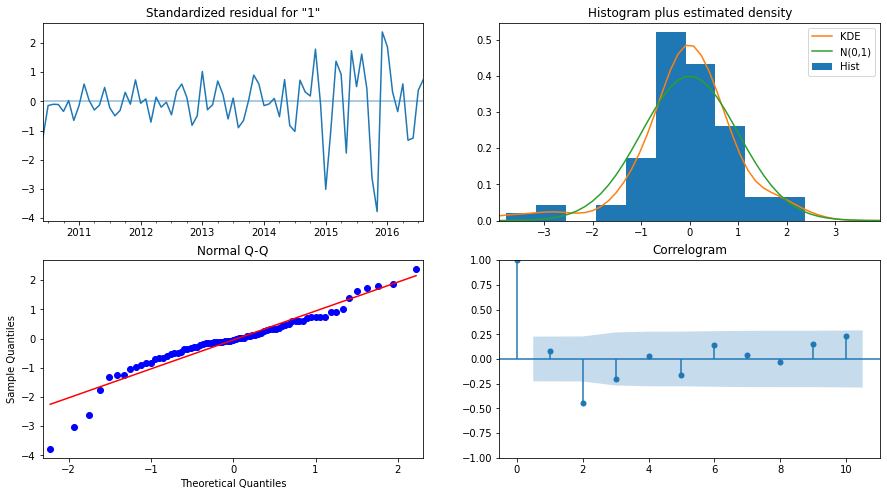

In [10]:
# residual diagnostics
output_11216.plot_diagnostics(figsize = (15,8))

plt.show()

### Summary and Residual Diagnostics for Zip Code 33936

In [11]:
print(output_33936.summary())

                               SARIMAX Results                                
Dep. Variable:                  33936   No. Observations:                   80
Model:                 ARIMA(0, 2, 0)   Log Likelihood                -552.870
Date:                Wed, 17 Mar 2021   AIC                           1107.739
Time:                        19:19:34   BIC                           1110.096
Sample:                    01-01-2010   HQIC                          1108.683
                         - 08-01-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      8.393e+04   1.25e+04      6.726      0.000    5.95e+04    1.08e+05
Ljung-Box (L1) (Q):                   2.30   Jarque-Bera (JB):                 0.36
Prob(Q):                              0.13   Pr

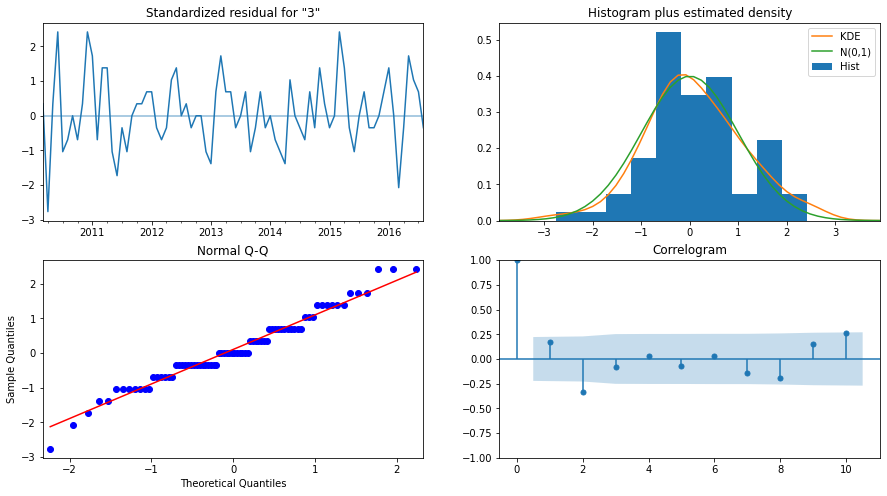

In [12]:
# residual diagnostics
output_33936.plot_diagnostics(figsize = (15,8))

plt.show()

### Summary and Residual Diagnostics for Zip Code 94804

In [13]:
print(output_94804.summary())

                               SARIMAX Results                                
Dep. Variable:                  94804   No. Observations:                   80
Model:                 ARIMA(3, 0, 0)   Log Likelihood                   0.000
Date:                Wed, 17 Mar 2021   AIC                             10.000
Time:                        19:19:35   BIC                             21.910
Sample:                    01-01-2010   HQIC                            14.775
                         - 08-01-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.387e+05         -0       -inf      0.000    2.39e+05    2.39e+05
ar.L1          3.0000   1.18e-07   2.55e+07      0.000       3.000       3.000
ar.L2         -3.0000   1.18e-07  -2.55e+07      0.0

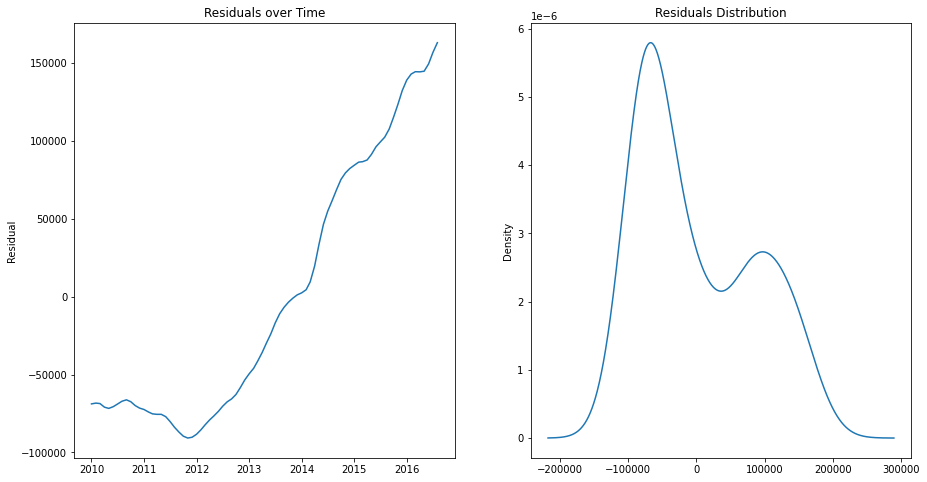

In [14]:
# manually plotting residual plots
fig, axes = plt.subplots(1, 2, figsize = (15,8))

axes[0].plot(output_94804.resid)
axes[0].set_title("Residuals over Time")
axes[0].set_ylabel("Residual")
output_94804.resid.plot(kind = "kde", title = "Residuals Distribution",
                        ax = axes[1]);

### Summary and Residual Diagnostics for Zip Code 11222

In [15]:
print(output_11222.summary())

                               SARIMAX Results                                
Dep. Variable:                  11222   No. Observations:                   80
Model:                 ARIMA(2, 5, 2)   Log Likelihood                -801.255
Date:                Wed, 17 Mar 2021   AIC                           1612.510
Time:                        19:19:36   BIC                           1624.097
Sample:                    01-01-2010   HQIC                          1617.136
                         - 08-01-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0349      0.116      0.302      0.763      -0.192       0.261
ar.L2         -0.4767      0.106     -4.511      0.000      -0.684      -0.270
ma.L1         -1.9865      0.178    -11.176      0.0

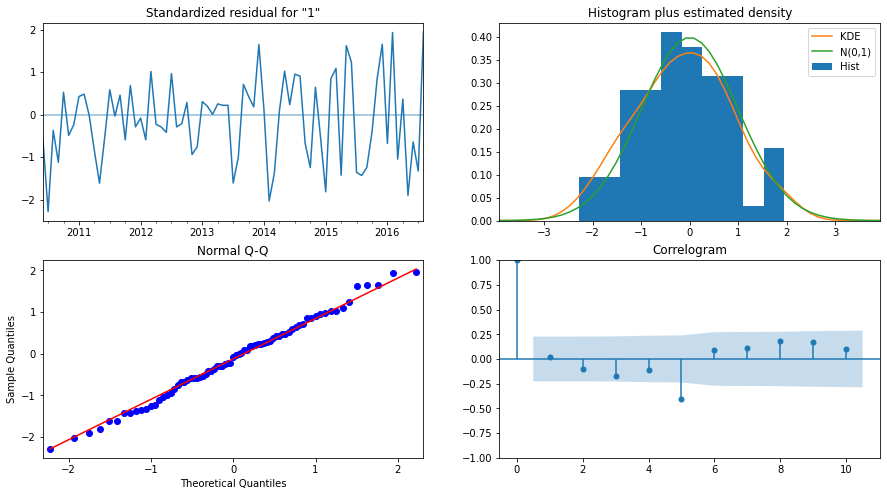

In [16]:
# residual diagnostics
output_11222.plot_diagnostics(figsize = (15,8))

plt.show()

### Summary and Residual Diagnostics for Zip Code 94301

In [17]:
print(output_94301.summary())

                               SARIMAX Results                                
Dep. Variable:                  94301   No. Observations:                   80
Model:                 ARIMA(3, 1, 1)   Log Likelihood                   0.000
Date:                Wed, 17 Mar 2021   AIC                             10.000
Time:                        19:19:37   BIC                             21.847
Sample:                    01-01-2010   HQIC                            14.746
                         - 08-01-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0000         -0        inf      0.000      -1.000      -1.000
ar.L2          1.0000         -0       -inf      0.000       1.000       1.000
ar.L3          1.0000   8.54e-08   1.17e+07      0.0

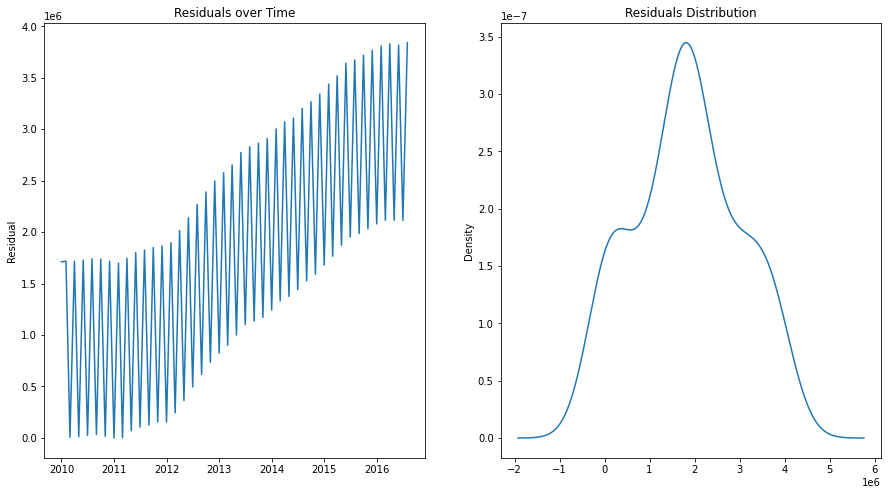

In [18]:
# manually plotting residual plots
fig, axes = plt.subplots(1, 2, figsize = (15,8))

axes[0].plot(output_94301.resid)
axes[0].set_title("Residuals over Time")
axes[0].set_ylabel("Residual")
output_94301.resid.plot(kind = "kde", title = "Residuals Distribution",
                        ax = axes[1]);

## Thoughts on Initial ARIMA Models

The ARIMA model summaries and residual diagnostics are summarized below:

- Fortunately, with the exception of 1 coefficient (zip code 11222), all other AR and MA coefficients are statistically significant for all models

- Residual diagnostics for the models with the lowest AIC scores (94804 and 94301) were the worst.  Had to plot residual plots manually because `plot_diagnostics()` was throwing an error.  Residuals are clearly not centred around 0 (have an upward trend in both cases) and distribution does *not* look normal

- All other models have good residual diagnostics.  ARIMA Model 11216 has residuals with non-constant variance but the distribution resembles a standard normal.  Other models have residuals centred around 0 and have relatively constant variance

## Evaluating Model's Performance Through Test MSE

Now that we've inspected each model's residual diagnostics, let's assess how well the model performs on unseen data.  Calculating the testing mean squared error (MSE) is another way to measure the quality of a model.  We'll create ARIMA models, fit to the training set, predict values outside the range of the training set, and calculate the model's test MSE.

**Note**: seeing as these are our first ARIMA models (no parameter tuning), we'll use the parameter values returned by our grid search when fitting the ARIMA model to the training data.

### Test Mean Squared Errors

The Mean Squared Error of our forecasts is 37412565181.16


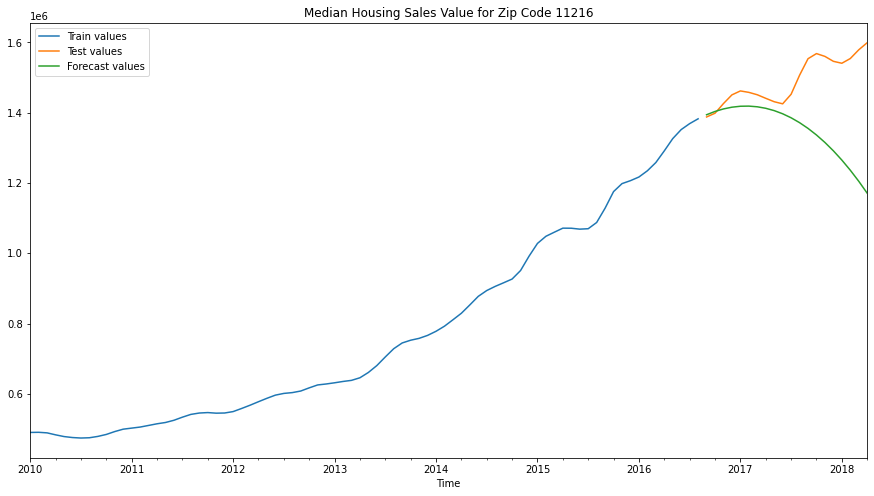

In [19]:
forecast = output_11216.predict("2016-09-01", end = "2018-04-01", dynamic = False)

ax = train["11216"].plot(title = "Median Housing Sales Value for Zip Code 11216",
                         xlabel = "Time", label = "Train values", figsize = (15,8))
test["11216"].plot(label = "Test values", ax = ax)
forecast.plot(label = "Forecast values", ax = ax)
plt.legend();

# Compute the mean square error
mse = ((forecast - test["11216"])**2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 83076000.0


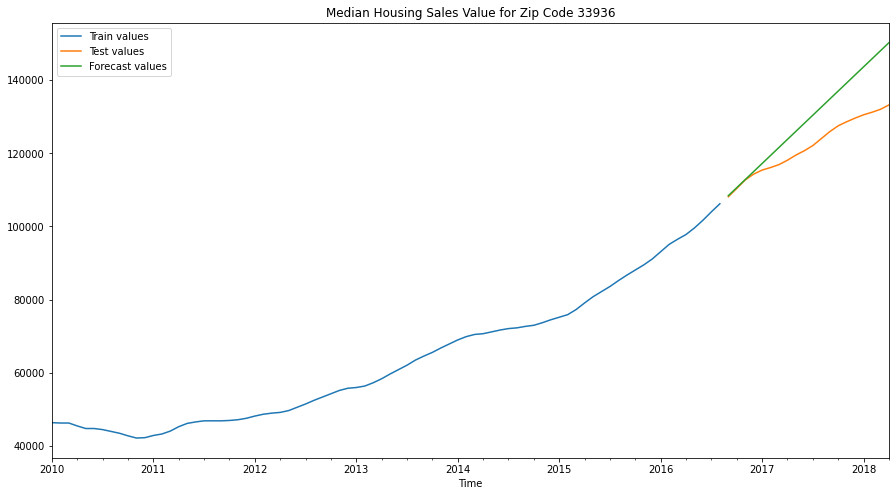

In [20]:
forecast = output_33936.predict("2016-09-01", end = "2018-04-01", dynamic = False)

ax = train["33936"].plot(title = "Median Housing Sales Value for Zip Code 33936",
                         xlabel = "Time", label = "Train values", figsize = (15,8))
test["33936"].plot(label = "Test values", ax = ax)
forecast.plot(label = "Forecast values", ax = ax)
plt.legend();

# Compute the mean square error
mse = ((forecast - test["33936"])**2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 39373057967.62


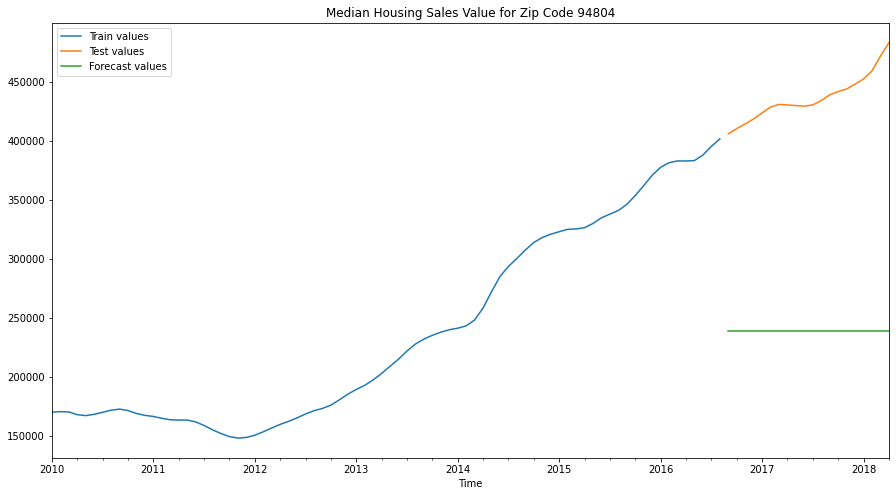

In [21]:
forecast = output_94804.predict("2016-09-01", end = "2018-04-01", dynamic = False)

ax = train["94804"].plot(title = "Median Housing Sales Value for Zip Code 94804",
                         xlabel = "Time", label = "Train values", figsize = (15,8))
test["94804"].plot(label = "Test values", ax = ax)
forecast.plot(label = "Forecast values", ax = ax)
plt.legend();

# Compute the mean square error
mse = ((forecast - test["94804"])**2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 1448649230194.62


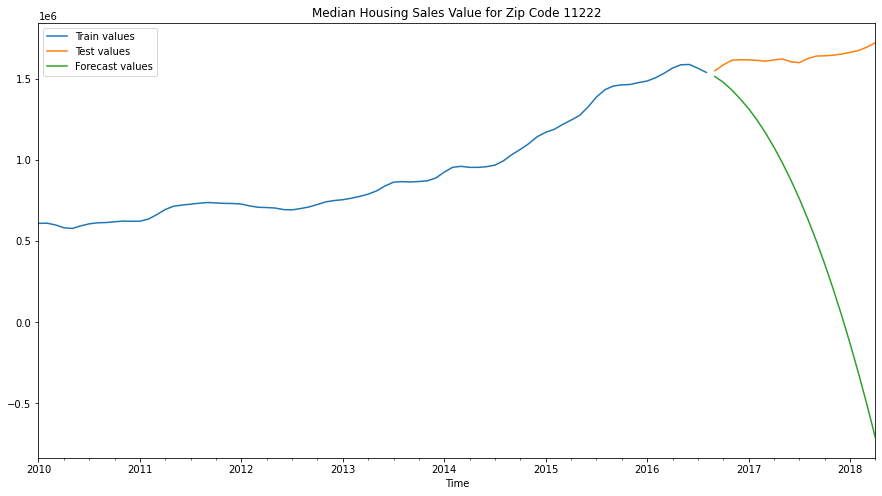

In [22]:
forecast = output_11222.predict("2016-09-01", end = "2018-04-01", dynamic = False)

ax = train["11222"].plot(title = "Median Housing Sales Value for Zip Code 11222",
                         xlabel = "Time", label = "Train values", figsize = (15,8))
test["11222"].plot(label = "Test values", ax = ax)
forecast.plot(label = "Forecast values", ax = ax)
plt.legend();

# Compute the mean square error
mse = ((forecast - test["11222"])**2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 12423558370338.89


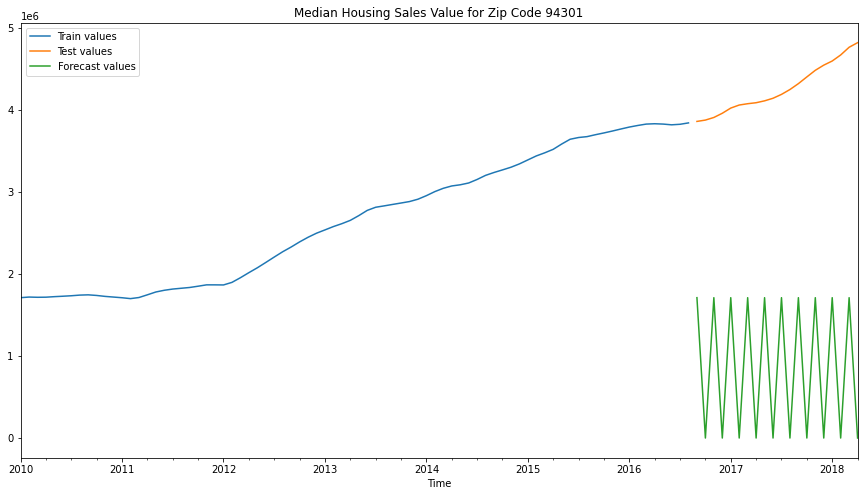

In [23]:
forecast = output_94301.predict("2016-09-01", end = "2018-04-01", dynamic = False)

ax = train["94301"].plot(title = "Median Housing Sales Value for Zip Code 94301",
                         xlabel = "Time", label = "Train values", figsize = (15,8))
test["94301"].plot(label = "Test values", ax = ax)
forecast.plot(label = "Forecast values", ax = ax)
plt.legend();

# Compute the mean square error
mse = ((forecast - test["94301"])**2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

## Thoughts on MSE Results

As seen by the plots above, the difference between the forecasted values and the actual test values is substantially large.  Unfortunately, using AIC as our paramter-choosing criterion, our models performed very poorly on new data.

----

## Steps Going Forward

Having created our ARIMA models with the initial parameter values returned by the exhaustive grid search, it is clear that further model tuning is needed.  Residual requirements failed in some instances and test mean squared errors were substantially high.  In the next [notebook](Tuning_ARIMA.ipynb), we'll try and tune each model by selecting parameter values using a different criterion.